
# Parallelize code with `dask.delayed`

In this section we parallelize simple for-loop style code with Dask and `dask.delayed`. Often, this is the only one function that you will need to convert functions for use with Dask.

This is a simple way to use `dask` to parallelize existing codebases or build [complex systems](http://matthewrocklin.com/blog/work/2018/02/09/credit-models-with-dask).  This will also help us to develop an understanding for later sections.

## Basics

First let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally.

In the next section we'll parallelize this code.

In [1]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

We time the execution of this normal code using the `%%time` magic, which is a special function of the Jupyter Notebook.

In [2]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 582 µs, sys: 1.11 ms, total: 1.69 ms
Wall time: 3.01 s


### Parallelize with the `dask.delayed` decorator

Those two increment calls *could* be called in parallel, because they are totally independent of ane-another.

We'll transform the `inc` and `add` functions using the `dask.delayed` function. When we call the delayed version by passing the arguments, exactly as before, but the original function isn't actually called yet - which is why the cell execution finishes very quickly.
Instead, a *delayed object* is made, which keeps track of the function to call and the arguments to pass to it.


In [3]:
from dask import delayed

In [4]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 810 µs, sys: 402 µs, total: 1.21 ms
Wall time: 996 µs


This ran immediately, since nothing has really happened yet.

To get the result, call `compute`. Notice that this runs faster than the original code.

In [5]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 6.88 ms, sys: 3.09 ms, total: 9.97 ms
Wall time: 2.01 s


5

## What just happened?

The `z` object is a lazy `Delayed` object.  This object holds everything we need to compute the final result, including references to all of the functions that are required and their inputs and relationship to one-another.  We can evaluate the result with `.compute()` as above or we can visualize the task graph for this value with `.visualize()`.

In [6]:
z

Delayed('add-29861fd0-c115-4afa-ac4e-181f158367c5')

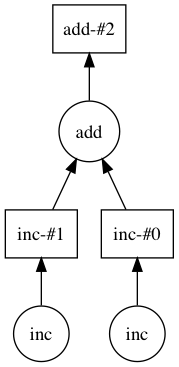

In [7]:
# Look at the task graph for `z`
z.visualize()

Notice that this includes the names of the functions from before, and the logical flow of the outputs of the `inc` functions to the inputs of `add`.

### Some questions to consider:

-  Why did we go from 3s to 2s?  Why weren't we able to parallelize down to 1s?

Answer: Two sleep() instances are dependent on each other i.e [ sleep in inc and sleep in add ]
-  What would have happened if the inc and add functions didn't include the `sleep(1)`?  Would Dask still be able to speed up this code?

Answer: No. The Python calls would outperform the dask version due to its preprocessing overhead.

-  What if we have multiple outputs or also want to get access to x or y?

Answer: The order of execution of the independent tasks depends on scheduler, but the dependent tasks add( ) will execute as expected.

## Parallelize a for loop

`for` loops are one of the most common things that we want to parallelize.  Use `dask.delayed` on `inc` and `sum` to parallelize the computation below:

In [8]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [9]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 8.31 ms, sys: 3.65 ms, total: 12 ms
Wall time: 8.01 s


In [10]:
total

44

In [11]:
%%time
# dask verison 
results = []
for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

CPU times: user 1.95 ms, sys: 1.07 ms, total: 3.02 ms
Wall time: 2.23 ms


In [12]:
%%time 
total.compute()

CPU times: user 5.91 ms, sys: 2.52 ms, total: 8.42 ms
Wall time: 2.01 s


44

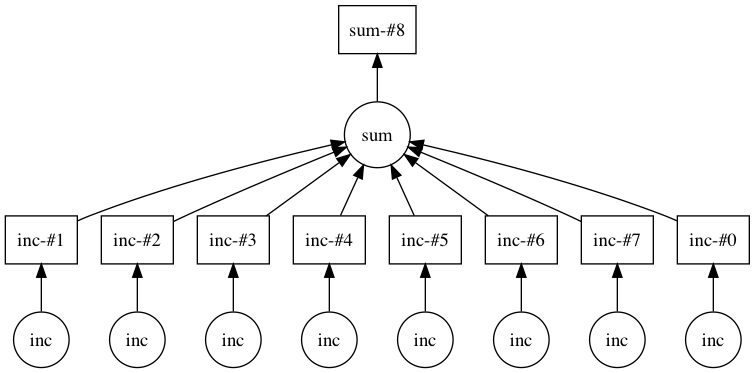

In [14]:
total.visualize()

How do the graph visualizations compare with the given solution, compared to a version with the `sum` function used directly rather than wrapped with `delay`? Can you explain the latter version? You might find the result of the following expression illuminating
```python
delayed(inc)(1) + delayed(inc)(2)
```

## Parallelizing a for-loop code with control flow

Often we want to delay only *some* functions, running a few of them immediately.  This is especially helpful when those functions are fast and help us to determine what other slower functions we should call.  This decision, to delay or not to delay, is usually where we need to be thoughtful when using `dask.delayed`.

In the example below we iterate through a list of inputs.  If that input is even then we want to call `inc`.  If the input is odd then we want to call `double`.  This `is_even` decision to call `inc` or `double` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [15]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [16]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

90
CPU times: user 10.1 ms, sys: 3.47 ms, total: 13.5 ms
Wall time: 10 s


In [20]:
%%time
results = []
for x in data:
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

CPU times: user 1.52 ms, sys: 1.09 ms, total: 2.61 ms
Wall time: 1.8 ms


In [21]:
%%time 
total.compute()

CPU times: user 6.46 ms, sys: 2.56 ms, total: 9.02 ms
Wall time: 3.01 s


90

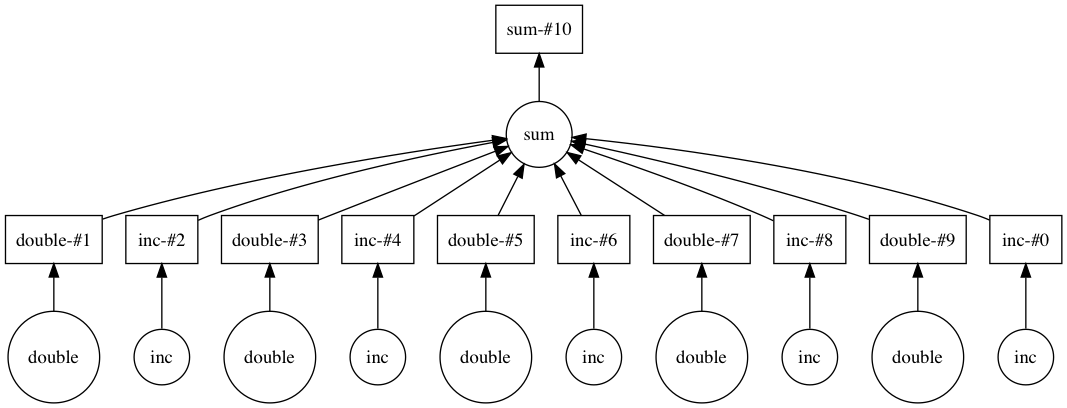

In [22]:
total.visualize()

## Demo: Parallelizing a Pandas Groupby Reduction

In this demonstration we read several CSV files and perform a groupby operation in parallel.  We have a sequential code to do this and we'll parallelize it with `dask.delayed`.

The computation we will parallelize is to compute the mean departure delay per airport from some historical flight data.  We will do this by using `dask.delayed` together with `pandas`.

### Inspect data

In [23]:
import os
sorted(os.listdir(os.path.join('data', 'nycflights')))

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

### Read one file with `pandas.read_csv` and compute mean departure delay

In [24]:
import pandas as pd
df = pd.read_csv(os.path.join('data', 'nycflights', '1990.csv'))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [25]:
# What is the schema?
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum              float64
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
Diverted               int64
dtype: object

In [26]:
# What originating airports are in the data?
df.Origin.unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [27]:
# Mean departure delay per-airport for one year
df.groupby('Origin').DepDelay.mean()

Origin
EWR     9.168411
JFK    11.857274
LGA     8.560045
Name: DepDelay, dtype: float64

### Sequential code: Mean Departure Delay Per Airport

The above cell computes the mean departure delay per-airport for one year. 
Here we expand that to all years using a sequential for loop.

In [29]:
from glob import glob
filenames = sorted(glob(os.path.join('data', 'nycflights', '*.csv')))

In [30]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 5.89 s, sys: 788 ms, total: 6.67 s
Wall time: 6.7 s


In [31]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### Parallelize the code above

We will use `dask.delayed` to parallelize the code above. 

Our goal is to parallelize the code above (which has been copied below) using `dask.delayed`.

In [38]:
from dask import compute

In [49]:
%%time
sums = []
counts = []
for fn in filenames:
    # Read in file
    #df = pd.read_csv(fn)
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
#sums, counts = compute(sums, counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 12.4 ms, sys: 13.4 ms, total: 25.8 ms
Wall time: 24.3 ms


In [50]:
%%time
# ensure the results still match
mean.compute()

CPU times: user 17.3 s, sys: 1.96 s, total: 19.2 s
Wall time: 7.14 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### Some questions to consider:

- How much speedup did you get? 

A: ~ 1.8x
- Experiment with where to call `compute`. What happens when you call it on `sums` and `counts`? What happens if you wait and call it on `mean`?

A: Calling on mean is slightly faster. 